# Do Wrestlers Live Shorter Lives Than Other Athletes??

This is still a complete work in progress.

Scraping the data was the easy part. 

Luckily Wikipedia has a great function available [here](https://en.wikipedia.org/wiki/Special:Export) that allows you to download the xml and wikimedia data from multiple files at a time. They also have the lists of players for every major sports league:

* [NBA](https://en.wikipedia.org/wiki/Lists_of_National_Basketball_Association_players)
* [NHL](https://en.wikipedia.org/wiki/List_of_NHL_players)

I didn't need to scrape NFL or MLB data because luckily someone already did that:

* [MLB](http://www.seanlahman.com/baseball-archive/statistics/)
* [NFL](http://nflsavant.com/about.php)

I did update both datasets to include the last few years of deaths among players.

Unluckily parsing and cleaning is an absolute mess. Unfortunately on Wikipedia, many athletes are missing infobox data despite the information being listed right on the page, so parsing is not automatic. It works for probably 75% of the data, now I have to sift through the wikimedia data and add lines to account for the missing data so that the program I've written can parse properly. Fun!

For wrestlers, I've opted to choose the largest American promotions for the data which includes:

* WWF/WWE/WWWF
* WCW
* ECW
* AWA
* NWA
* Stampede Pro Wrestling
* TNA

Finally, I'll be calculating the lifespan **BASED ON ATHLETES WHO HAVE PASSED AWAY**. I've calculated the ages of everyone who has passed away and averaged over that sample to find the average lifespan. I will probably interchange lifespan and life expectancy, even though life expectancy is technically a more complicated calculation.

* MLB data is current as of June 24, 2016
* NBA data is current as of June 24, 2016
* NHL data is current as of June 24, 2016
* NFL data is current as of June 24, 2016
* Wrestling data is current as of June 24, 2016

## General Information about Each League

* MLB - 1876
* NFL - 1920
* NHL - 1917
* NBA - Founded 1946
* Professional Wrestling - 1800s

In order to keep the lifespans consistent, I'll only be using athletes born in or after 1910. Using athletes born prior to these years might skew the lifepans downwards as life expectancies have increased steadily throughout the decades.

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

mlb_all = pd.read_csv('csvs/mlb.csv')
nfl_all = pd.read_csv('csvs/nfl.csv')
nhl_all = pd.read_csv('csvs/nhl.csv')
nba_all = pd.read_csv('csvs/nba.csv')
wre_all = pd.read_csv('csvs/wrestling.csv')
wre_men = wre_all[wre_all['sex'] == 'm']

#earliest birth year to start with
start_year = 1910

In [2]:
# Helper methods

def print_full(x):
    """print_full prints the entire dataframe instead of a snippet
    """
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def convert_date(x):
    other_format = '%m/%d/%Y'
    proper_format = '%Y-%m-%d'
    val = x
    try:
        val = datetime.strptime(x, other_format).strftime(proper_format)
    except:
        return val
    return val

def calculate_age(x):
    death_or_current = ''
    if pd.notnull(x['death_year']):
        death_or_current = datetime(int(x['death_year']), int(x['death_month']), int(x['death_day']))
    else:
        death_or_current = datetime.now()
 
    if pd.notnull(x['birth_year']):
        birth = datetime(int(x['birth_year']), int(x['birth_month']), int(x['birth_day']))
        return (death_or_current - birth).days
    else:
        return 0

def add_age_to_df(df):
    """age_age_to_df will add an age column to a dataframe and return a 
    new dataframe"""
    filler = ['birth_day', 'birth_month', 'death_day', 'death_month']
    dates = filler + ['birth_year', 'death_year']
    df[filler] = df[filler].fillna(1)

    df['age'] = df.apply(calculate_age, axis=1)
    return df

def split_date(x, col):
    if pd.isnull(x[col]):
        return np.nan, np.nan, np.nan
    d = datetime.strptime(x[col], proper_format)
    return d.year, d.month, d.day

def calculate(df, start_year):
    """calculate takes in a dataframe and a start year and returns a dictionary
    containing the following information:
    start_year
    total_athletes
    total_deaths
    lifespan
    youngest_death
    oldest_death
    
    Arguments
    ---------
    df : DataFrame
        pandas dataframe of the league data
    start_year : str
        earliest birth_year to start with
    """
    d = {}
    d['start_year'] = start_year
    df_sample = add_age_to_df(df)
    df_sample = df_sample[df_sample['birth_year'] >= start_year]
    d['total_athletes'] = len(df_sample)
    df_sample = df_sample[pd.notnull(df_sample['birth_year'])]
    df_sample = df_sample[pd.notnull(df_sample['death_year'])]

    df_by_age = df_sample.sort_values('age')

    if len(df_by_age) == 0:
        d['youngest_death'] = pd.Series({'name': None, 'age': None})
        d['oldest_death'] = pd.Series({'name': None, 'age': None})
    else:
        d['youngest_death']=  df_by_age.iloc[0]
        d['oldest_death'] = df_by_age.iloc[-1]

    d['total_deaths'] = len(df_sample)
    d['lifespan'] = np.mean(df_sample['age']) / 365.25

    return d

def print_data(d):
    """print_data takes in a dictionary of information and prints it
    cleanly.
    """
    print 'Total number of athletes born after {}: {}'.format(d['start_year'], d['total_athletes'])
    print 'Total number of deaths of athletes born after {}: {}'.format(d['start_year'], d['total_deaths'])
    print('Percentage of population born since {} that has died: {:.2%}'
        .format(d['start_year'], float(d['total_deaths'])/d['total_athletes']))
    print "Average Age: {}".format(d['lifespan'])
    print 'Youngest person to die: {} at age {}'.format(d['youngest_death']['name'], d['youngest_death']['age']/365.25)
    print 'Oldest person to die: {} at age {}'.format(d['oldest_death']['name'], d['oldest_death']['age']/365.25)

In [3]:
# Drop deceased athletes with unknown death dates

nfl_all = nfl_all[nfl_all['death_year'] != 'd']
mlb_all = mlb_all[mlb_all['death_year'] != 'd']
nhl_all = nhl_all[nhl_all['death_year'] != 'd']

# Split nfl_all birthdates and deathdates into three columns each

proper_format = '%Y-%m-%d'
if 'birth_date' in nfl_all:

    nfl_all['death_date'] = nfl_all['death_date'].apply(convert_date)
    nfl_all['birth_date'] = nfl_all['birth_date'].apply(convert_date)
    nfl_all['birth_year'], nfl_all['birth_month'], nfl_all['birth_day'] = zip(*nfl_all.apply(split_date, axis=1, args=('birth_date',)))
    nfl_all['death_year'], nfl_all['death_month'], nfl_all['death_day'] = zip(*nfl_all.apply(split_date, axis=1, args=('death_date',)))
    nfl_all = nfl_all.drop(['birth_date', 'death_date'], axis=1)

# Combine mlb 'name_first' and 'name_last' into one 'name' column

mlb_all = mlb_all[mlb_all['death_year'] != 'd']
if 'name_first' in mlb_all:
    mlb_all['name'] = mlb_all['name_first'] + ' ' + mlb_all['name_last']
    mlb_all = mlb_all.drop(['name_first', 'name_last'], axis=1)



## Basic Stats

Let's start with some basic stats on the data.

In [4]:
mlb_len = len(mlb_all)
nhl_len = len(nhl_all)
nfl_len = len(nfl_all)
nba_len = len(nba_all)
wre_all_len = len(wre_all)
wre_men_len = len(wre_men)

print "Total Number of Athletes\n------------------------"
print "{}:                      {}".format("mlb", mlb_len)
print "{}:                      {}".format("nfl", nfl_len)
print "{}:                      {}".format("nhl", nhl_len)
print "{}:                      {}".format("nba", nba_len)
print "{}: {}".format("wrestling(men and women)", wre_all_len)
print "{}:           {}".format("wrestling(men)", wre_men_len)

Total Number of Athletes
------------------------
mlb:                      18787
nfl:                      23620
nhl:                      7114
nba:                      4543
wrestling(men and women): 1513
wrestling(men):           1345


### Oldest and youngest players to die

In [5]:
all_leagues = [mlb_all, nfl_all, nba_all, nhl_all, wre_men]
leagues = ['MLB', 'NFL', 'NBA', 'NHL', 'Wrestling']

# Create dict for later when creating the json file
d = {}
d['oldestYoungest'] = []

for i, league in enumerate(all_leagues):
    l = calculate(league, 1800)
    d['oldestYoungest'] = np.hstack((d['oldestYoungest'],
        {'league': leagues[i], 'oldestName': l['oldest_death']['name'], 'oldestAge': l['oldest_death']['age'],
        'youngestName': l['youngest_death']['name'], 'youngestAge': l['youngest_death']['age']})).tolist()

print d

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{'oldestYoungest': [{'league': 'MLB', 'youngestAge': 7137, 'oldestAge': 39213, 'youngestName': 'Jay Dahl', 'oldestName': 'Red Hoff'}, {'league': 'NFL', 'youngestAge': 8014, 'oldestAge': 38069, 'youngestName': 'Lucien Reeberg', 'oldestName': 'Sam Salemi'}, {'league': 'NBA', 'youngestAge': 8681, 'oldestAge': 36393, 'youngestName': 'Bryce Dejean-Jones', 'oldestName': 'John Wooden'}, {'league': 'NHL', 'youngestAge': 7440, 'oldestAge': 36854, 'youngestName': 'Dudley Garrett', 'oldestName': 'Al Suomi'}, {'league': 'Wrestling', 'youngestAge': 9334, 'oldestAge': 36312, 'youngestName': 'David Von Erich', 'oldestName': 'Angelo Savoldi'}]}


### MLB Data

In [6]:
mlb_data = calculate(mlb_all, start_year)
print_data(mlb_data)

Total number of athletes born after 1910: 12232
Total number of deaths of athletes born after 1910: 2939
Percentage of population born since 1910 that has died: 24.03%
Average Age: 70.444028814
Youngest person to die: Jay Dahl at age 19.5400410678
Oldest person to die: Connie Marrero at age 102.995208761


### NFL Data

In [7]:
# Add recent deaths
def add_death(name, death_date):
    idx = nfl[nfl['name'] == name].index
    if len(idx) == 0:
        print "Not found"
        return
    nfl.set_value(idx[0], 'death_date', death_date)
    nfl.to_csv('csvs/nfl.csv', index=False)

nfl_data = calculate(nfl_all, start_year)
print_data(nfl_data)

Total number of athletes born after 1910: 21383
Total number of deaths of athletes born after 1910: 4116
Percentage of population born since 1910 that has died: 19.25%
Average Age: 68.5929136493
Youngest person to die: Lucien Reeberg at age 21.9411362081
Oldest person to die: Ace Parker at age 101.472963723


### NBA Data

In [8]:
nba_data = calculate(nba_all, start_year)
print_data(nba_data)

Total number of athletes born after 1910: 4531
Total number of deaths of athletes born after 1910: 979
Percentage of population born since 1910 that has died: 21.61%
Average Age: 69.0691600965
Youngest person to die: Bryce Dejean-Jones at age 23.7672826831
Oldest person to die: John Wooden at age 99.6386036961


### NHL Data

In [9]:
nhl_data = calculate(nhl_all, start_year)
print_data(nhl_data)

Total number of athletes born after 1910: 6671
Total number of deaths of athletes born after 1910: 923
Percentage of population born since 1910 that has died: 13.84%
Average Age: 68.6026060009
Youngest person to die: Dudley Garrett at age 20.3696098563
Oldest person to die: Al Suomi at age 100.900752909


### Wrestling Data

In [10]:
wre_data = calculate(wre_men, start_year)
print_data(wre_data)

Total number of athletes born after 1910: 1292
Total number of deaths of athletes born after 1910: 303
Percentage of population born since 1910 that has died: 23.45%
Average Age: 60.5267516485
Youngest person to die: David Von Erich at age 25.5550992471
Oldest person to die: Angelo Savoldi at age 99.4168377823


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


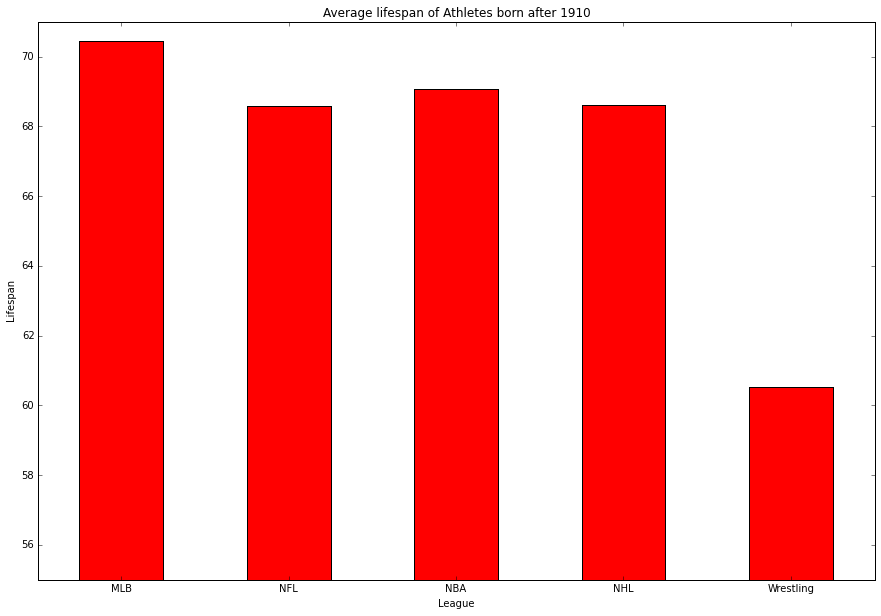

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

datasets = [mlb_data, nfl_data, nba_data, nhl_data, wre_data]

d['lifespans'] = []

for i, l in enumerate(datasets):
    d['lifespans'] = np.hstack((d['lifespans'],{'league': leagues[i], 'age': l['lifespan']})).tolist()
indices = np.arange(5)
width = 0.5

plt.figure(figsize=[15,10])
plt.bar(indices + width, [li['lifespan'] for li in datasets], width, color='r', align='center')
plt.xticks(indices + width, ['MLB', 'NFL', 'NBA', 'NHL', 'Wrestling'])
plt.title('Average lifespan of Athletes born after {}'.format(start_year))
plt.xlabel('League')
plt.ylabel('Lifespan')
plt.ylim([55, 71])

plt.show()

The differences between the MLB, NHL, NFL, and NBA are small, but the average lifespan of a wrestler is nearly 10 years less than a baseplayer's lifespan! This number could be a bit deceiving though. We have a much smaller sample size of wrestlers compared to the other leagues. I could expand the sample size a bit by including wrestlers from independent promotions, but there's not a great deal of data available. So instead, I'll shrink the sample sizes of the NBA, MLB, NFL, and NHL to compare the life expectancy. I have a feeeling that average lifespan for each sample will decrease. With smaller sample sizes, means are more affected by outliers. Plus with more data, ages would most likely trend toward the average life expectancy of the whole population, which is considered somewhere between 75 and 80.

In [12]:
import random

n = wre_men_len
mlb_subsample = mlb_all.loc[random.sample(xrange(0, mlb_len), n)]
nba_subsample = nba_all.loc[random.sample(xrange(0, nba_len), n)]
nfl_subsample = nfl_all.loc[random.sample(xrange(0, nfl_len), n)]
nhl_subsample = nhl_all.loc[random.sample(xrange(0, nhl_len), n)]

print 'MLB\n---'
mlb_subsample_data = calculate(mlb_subsample, start_year)
print_data(mlb_subsample_data)
print '\n'
print 'NBA\n---'
nba_subsample_data = calculate(nba_subsample, start_year)
print_data(nba_subsample_data)
print '\n'
print 'NFL\n---'
nfl_subsample_data = calculate(nfl_subsample, start_year)
print_data(nfl_subsample_data)
print '\n'
print 'NHL\n---'
nhl_subsample_data = calculate(nhl_subsample, start_year)
print_data(nhl_subsample_data)

MLB
---
Total number of athletes born after 1910: 889
Total number of deaths of athletes born after 1910: 193
Percentage of population born since 1910 that has died: 21.71%
Average Age: 70.8437900083
Youngest person to die: Miguel Fuentes at age 23.7234770705
Oldest person to die: Moon Mullen at age 96.052019165


NBA
---
Total number of athletes born after 1910: 1342
Total number of deaths of athletes born after 1910: 309
Percentage of population born since 1910 that has died: 23.03%
Average Age: 68.594193364
Youngest person to die: Nick Vanos at age 24.3422313484
Oldest person to die: John Poncar at age 96.2108145106


NFL
---
Total number of athletes born after 1910: 1217
Total number of deaths of athletes born after 1910: 248
Percentage of population born since 1910 that has died: 20.38%
Average Age: 68.9814974277
Youngest person to die: Ralph Anderson at age 23.9014373717
Oldest person to die: Johnny Kovatch at age 101.297741273


NHL
---
Total number of athletes born after 1910: 

In [25]:
subsamples = [mlb_subsample_data, nfl_subsample_data, nba_subsample_data, nhl_subsample_data, wre_data]
d['adjustedLifespans'] = []
for i, l in enumerate(subsamples):
    d['adjustedLifespans'] = np.hstack((d['adjustedLifespans'],{'league': leagues[i], 'age': l['lifespan']})).tolist()

Even after limiting the sample size of all the sports leagues to match the size of the wrestling data (1345 athletes), wrestlers still lived a much shorter life. Originally I thought there would be some element of bias involved.

  * There are fewer wrestlers, so when a famous wrestler dies (Roddy Piper, Randy Savage, Chris Benoit, Dusty Rhodes, Ultimate Warrior), you are more prone to remembering it. 
  * From a personal standpoint, I hear more about the deaths of wrestlers than any other sport. I can name maybe ten baseball players who have died in the last ten years. Wrestlers, I can name at least double that.
  * Wrestling is of course more violent, therefore you would naturally think that the toll the body takes would lead to earlier deaths.
  
And, well, according to the data, wrestlers do live much shorter lives.

Let's see the percentage of the population that has died since being born each decade:

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


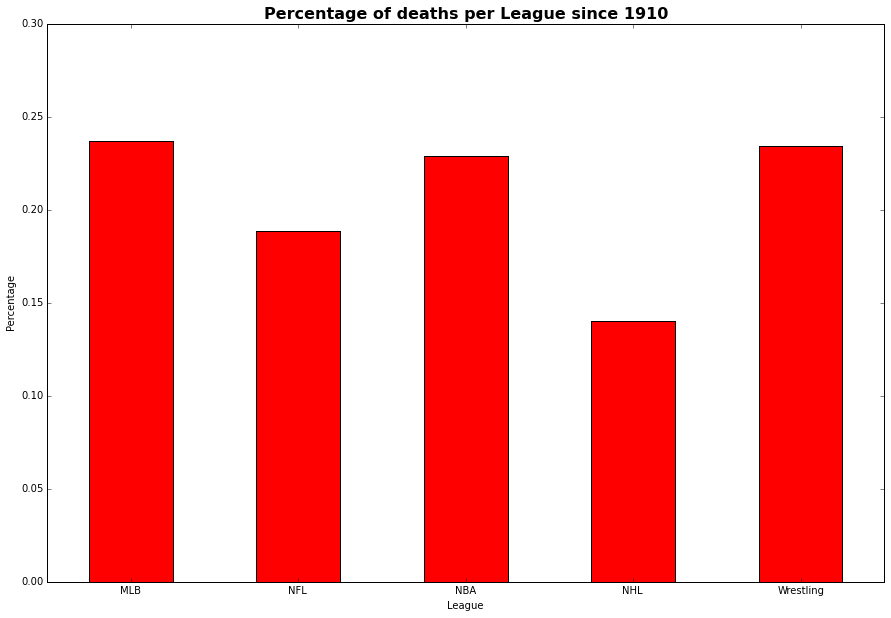

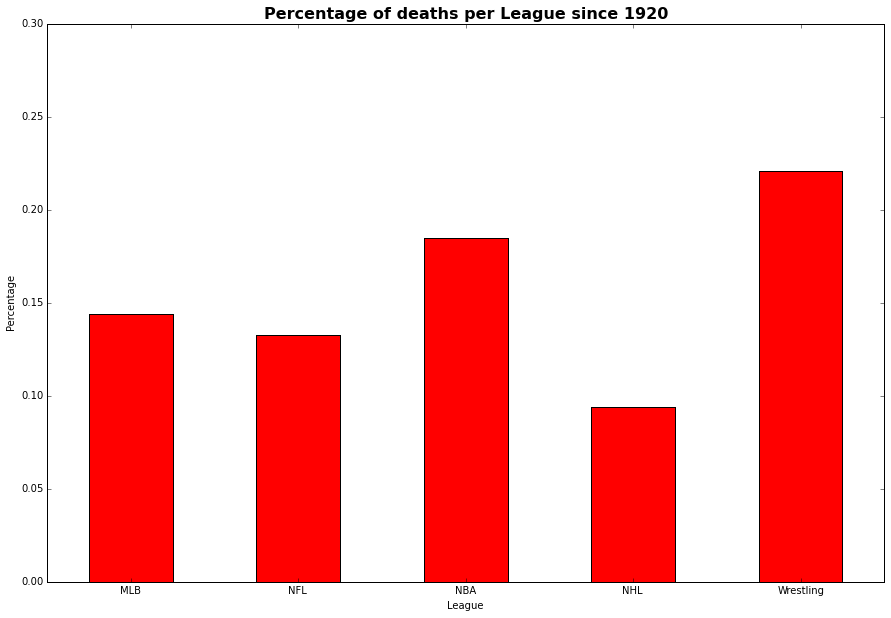

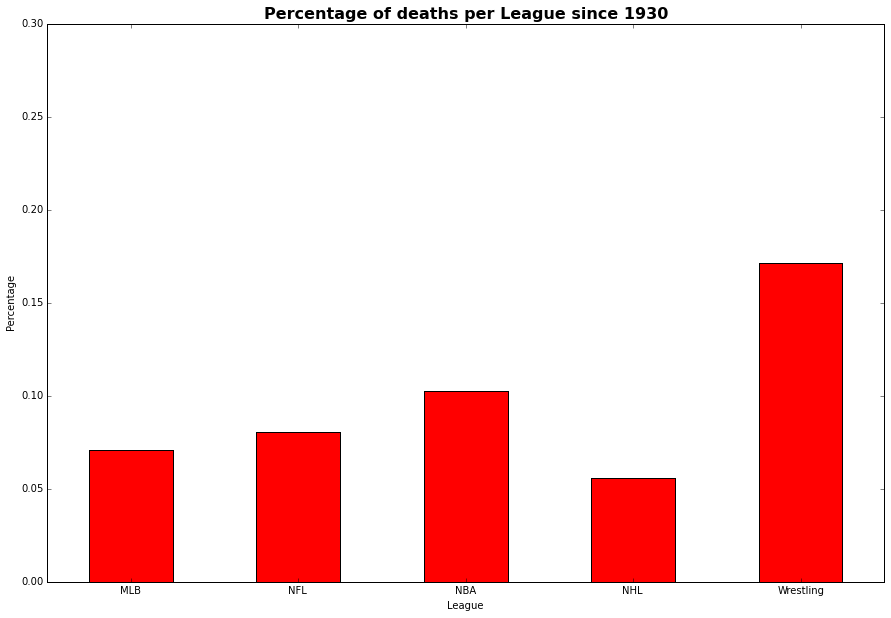

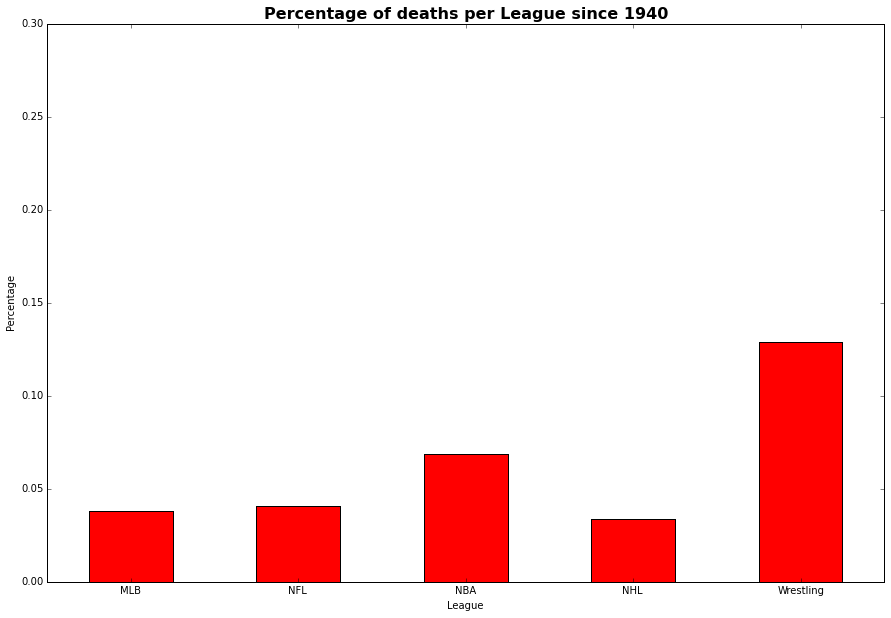

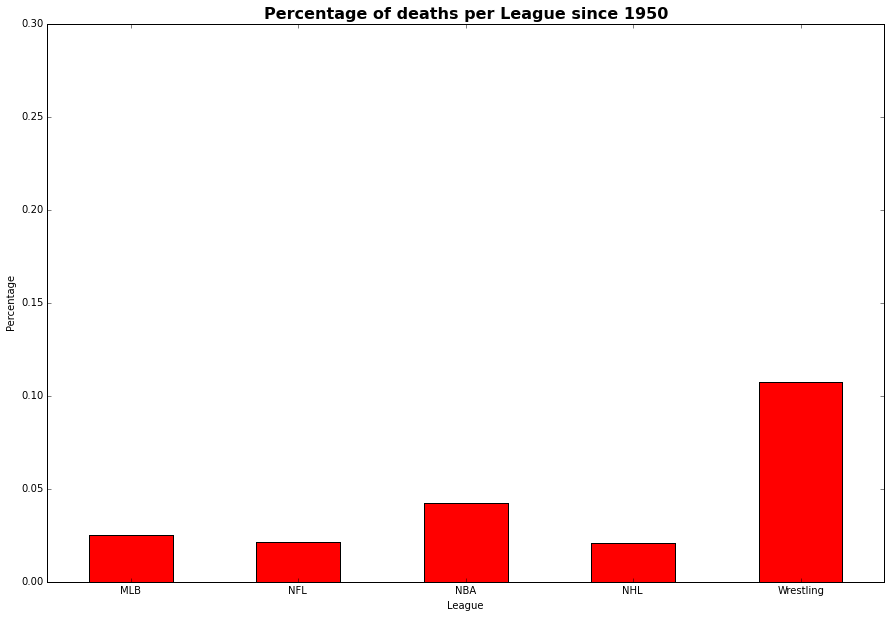

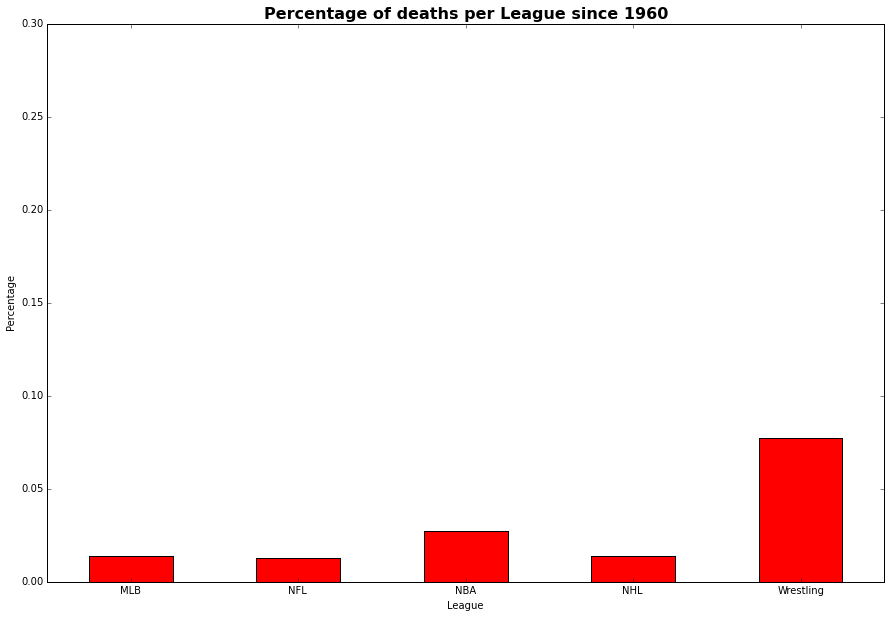

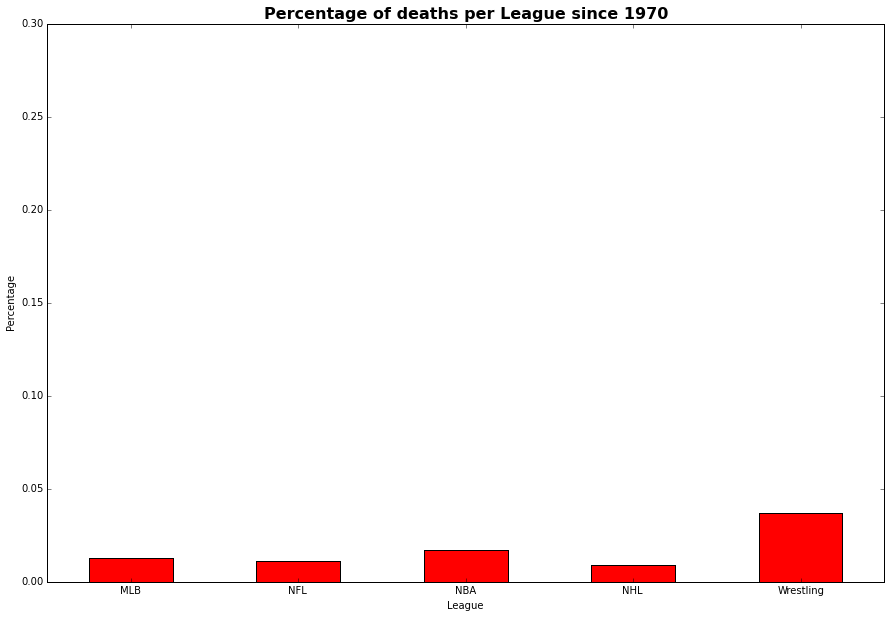

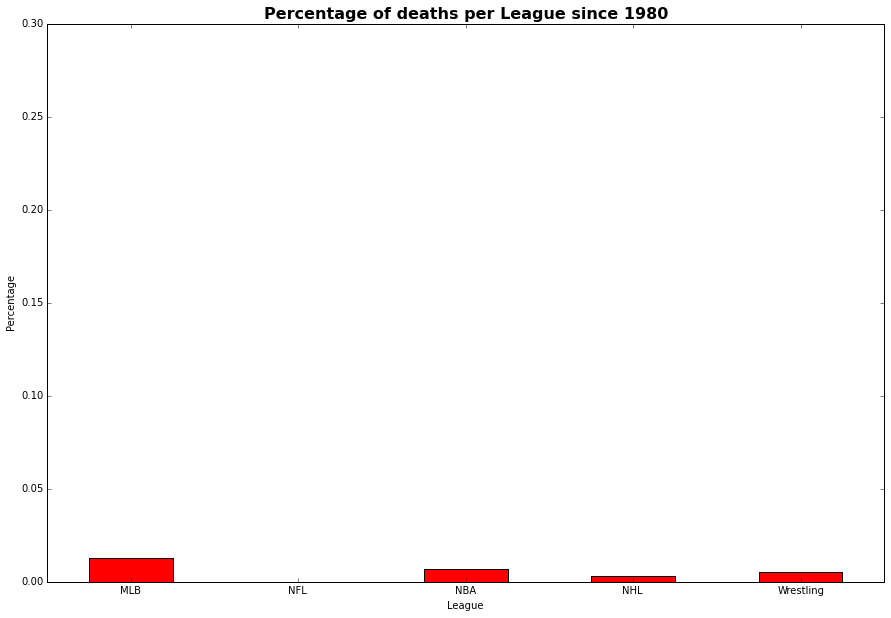

In [27]:
decades = np.arange(1910, 1990, 10)
league_samples = [mlb_subsample, nfl_subsample, nba_subsample, nhl_subsample, wre_men]
all_percentages = np.array([])
d['decades'] = {}

for i, l in enumerate(league_samples):
    percentages = np.array([])
    for de in decades:
        des = str(de) + 's'
        if not des in d['decades']:
            d['decades'][des] = []
        di = calculate(l, de)
        d['decades'][des] = np.hstack((d['decades'][des], {'league': leagues[i], 'value': float(di['total_deaths'])/di['total_athletes']})).tolist()
        percentages = np.hstack((percentages, float(di['total_deaths'])/di['total_athletes']))
    try:
        all_percentages = np.vstack((all_percentages, percentages))
    except:
        all_percentages = percentages

indices = np.arange(5)
width = 0.5

for i in range(len(decades)):
    plt.figure(figsize=[15,10])
    plt.bar(indices + width, all_percentages[:, i], width, color='r', align='center')
    plt.xticks(indices + width, leagues)
    plt.title('Percentage of deaths per League since {}'.format(decades[i]), fontweight='bold', fontsize=16)
    plt.xlabel('League')
    plt.ylabel('Percentage')
    plt.ylim([0, 0.3])

    plt.show()
    print '\n'

In [112]:
# Encode d into a json file to use on the website
import json

with open('wrestling_deaths.json', 'w') as f:
    f.write(json.dumps(d, sort_keys=True))

## Conclusion

Given the available data, wrestlers live shorter lives than other athletes by almost ten years! I don't have a solution to the issue. I don't know the schedules, I don't know the substances these performers use. Maybe these results are a result of the steroid era and the wrestlers' qualities of life have improved with more stringent drug testing. Heck, I don't know if I have a large enough sample size to make any sort of judgement. But it's something that perhaps needs to be looked at more closely.

## Resources

* [http://www.wrestlingdata.com/](http://www.wrestlingdata.com/)
* [http://www.baseball-almanac.com/players/baseball_deaths.php](http://www.baseball-almanac.com/players/baseball_deaths.php)
* [https://en.wikipedia.org/wiki/Deaths_in_2016](https://en.wikipedia.org/wiki/Deaths_in_2016)
* [http://www.pro-football-reference.com/](http://www.pro-football-reference.com/)